In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from decimal import ROUND_HALF_UP, Decimal
from sklearn.metrics import mean_squared_error
from scipy import stats
from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/jpx-tokyo-stock-exchange-prediction/stock_list.csv
/kaggle/input/jpx-tokyo-stock-exchange-prediction/example_test_files/sample_submission.csv
/kaggle/input/jpx-tokyo-stock-exchange-prediction/example_test_files/options.csv
/kaggle/input/jpx-tokyo-stock-exchange-prediction/example_test_files/financials.csv
/kaggle/input/jpx-tokyo-stock-exchange-prediction/example_test_files/secondary_stock_prices.csv
/kaggle/input/jpx-tokyo-stock-exchange-prediction/example_test_files/trades.csv
/kaggle/input/jpx-tokyo-stock-exchange-prediction/example_test_files/stock_prices.csv
/kaggle/input/jpx-tokyo-stock-exchange-prediction/jpx_tokyo_market_prediction/competition.cpython-37m-x86_64-linux-gnu.so
/kaggle/input/jpx-tokyo-stock-exchange-prediction/jpx_tokyo_market_prediction/__init__.py
/kaggle/input/jpx-tokyo-stock-exchange-prediction/data_specifications/stock_fin_spec.csv
/kaggle/input/jpx-tokyo-stock-exchange-prediction/data_specifications/trades_spec.csv
/kaggle/input/jpx-tokyo-stock-

In [3]:
train = pd.read_csv('/kaggle/input/jpx-tokyo-stock-exchange-prediction/train_files/stock_prices.csv')
train

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
0,20170104_1301,2017-01-04,1301,2734.0,2755.0,2730.0,2742.0,31400,1.0,NaN,False,0.000730
1,20170104_1332,2017-01-04,1332,568.0,576.0,563.0,571.0,2798500,1.0,NaN,False,0.012324
2,20170104_1333,2017-01-04,1333,3150.0,3210.0,3140.0,3210.0,270800,1.0,NaN,False,0.006154
3,20170104_1376,2017-01-04,1376,1510.0,1550.0,1510.0,1550.0,11300,1.0,NaN,False,0.011053
4,20170104_1377,2017-01-04,1377,3270.0,3350.0,3270.0,3330.0,150800,1.0,NaN,False,0.003026
...,...,...,...,...,...,...,...,...,...,...,...,...
2332526,20211203_9990,2021-12-03,9990,514.0,528.0,513.0,528.0,44200,1.0,NaN,False,0.034816
2332527,20211203_9991,2021-12-03,9991,782.0,794.0,782.0,794.0,35900,1.0,NaN,False,0.025478
2332528,20211203_9993,2021-12-03,9993,1690.0,1690.0,1645.0,1645.0,7200,1.0,NaN,False,-0.004302
2332529,20211203_9994,2021-12-03,9994,2388.0,2396.0,2380.0,2389.0,6500,1.0,NaN,False,0.009098


## Feature engineering

In [4]:
def adjust_price(price):
    price.loc[: ,"Date"] = pd.to_datetime(price.loc[: ,"Date"], format="%Y-%m-%d")

    def generate_adjusted_close(df):
        df = df.sort_values("Date", ascending=False)
        df.loc[:, "CumulativeAdjustmentFactor"] = df["AdjustmentFactor"].cumprod()
        df.loc[:, "AdjustedClose"] = (
            df["CumulativeAdjustmentFactor"] * df["Close"]
        ).map(lambda x: float(
            Decimal(str(x)).quantize(Decimal('0.1'), rounding=ROUND_HALF_UP)
        ))
        df = df.sort_values("Date")
        df.loc[df["AdjustedClose"] == 0, "AdjustedClose"] = np.nan
        df.loc[:, "AdjustedClose"] = df.loc[:, "AdjustedClose"].ffill()
        return df

    price = price.sort_values(["SecuritiesCode", "Date"])
    price = price.groupby("SecuritiesCode").apply(generate_adjusted_close).reset_index(drop=True)

    return price

In [6]:
def z_score(df):
    return stats.zscore(df)

In [7]:
def interpolate_nan(df):
    sec_codes = df.SecuritiesCode.unique().tolist()
    for code in sec_codes:
        df.loc[df.SecuritiesCode == code, "High"] = df[df.SecuritiesCode == code]["High"].interpolate(method='spline', order=3, limit_direction='both')
        df.loc[df.SecuritiesCode == code, "Low"] = df[df.SecuritiesCode == code]["Low"].interpolate(method='spline', order=3, limit_direction='both')
        df.loc[df.SecuritiesCode == code , "Close"] = df[df.SecuritiesCode == code]["Close"].interpolate(method='spline', order=3, limit_direction='both')
        df.loc[df.SecuritiesCode == code , "Open"] = df[df.SecuritiesCode == code]["Open"].interpolate(method='spline', order=3, limit_direction='both')
    return df

In [8]:
def ForceIndex(data, days = 10):
    FI = pd.Series(data['Close'].diff(days) * data['Volume'], name="ForceIndex")
    return FI

In [9]:
class ta:
    @classmethod
    def SMA(cls, ohlc, period=10, column='Close') -> pd.Series:
        """
        Simple moving average
        """
        return pd.Series(
            data=ohlc[column].rolling(window=period).mean(),
            dtype=float,
            name=f'{period} period SMA'
        )

    @classmethod
    def SMM(cls, ohlc, period=10, column='Close') -> pd.Series:
        """
        Simple moving median, an alternative to moving average
        """
        return pd.Series(
            data=ohlc[column].rolling(window=period).median(),
            dtype=float,
            name=f'{period} period SMM'
        )

    @classmethod
    def SSMA(cls, ohlc, period=10, column='Close', adjust=True) -> pd.Series:
        """
        Smoothed simple moving average
        """
        return pd.Series(
            ohlc[column].ewm(ignore_na=False, alpha=1.0 / period, min_periods=0, adjust=adjust).mean(),
            dtype=float,
            name=f'{period} period SSMA'
        )

    @classmethod
    def EMA(cls, ohlc, period=10, column='Close', adjust=True) -> pd.Series:
        """
        Exponential Moving Average
        """
        return pd.Series(
            data=ohlc[column].ewm(span=period, adjust=adjust).mean(),
            dtype=float,
            name=f'{period} period EMA'
        )

    @classmethod
    def DEMA(cls, ohlc, period=10, column='Close', adjust=True) -> pd.Series:
        """
        Double Exponential Moving Average
        """
        return pd.Series(
            data=2 * cls.EMA(ohlc, period, column) - cls.EMA(ohlc, period, column).ewm(span=period,
                                                                                       adjust=adjust).mean(),
            dtype=float,
            name=f'{period} period DEMA'
        )

    @classmethod
    def TEMA(cls, ohlc, period=10, column='Close', adjust=True) -> pd.Series:
        """
        Triple exponential moving average
        """
        triple_ema = 3 * cls.EMA(ohlc, period, column)
        ema_ema_ema = (
            cls.EMA(ohlc, period, column).
            ewm(ignore_na=False, span=period, adjust=adjust).mean().
            ewm(ignore_na=False, span=period, adjust=adjust).mean()
        )
        return pd.Series(
            data=triple_ema - 3 * cls.EMA(ohlc, period, column).ewm(span=period, adjust=adjust).mean() + ema_ema_ema,
            dtype=float,
            name=f'{period} period TEMA'
        )

    @classmethod
    def TRIMA(cls, ohlc, period=10, column='Close') -> pd.Series:
        """
        Triangular Moving Average
        """
        return pd.Series(
            data=cls.SMA(ohlc, period, column).rolling(window=period).sum() / period,
            dtype=float,
            name=f'{period} period TRIMA'
        )

    @classmethod
    def TRIX(cls, ohlc, period=10, column='Close', adjust=True) -> pd.Series:
        """
        The TRIX indicator calculates the rate of change of a triple exponential moving average.
        The values oscillate around zero. Buy/sell signals are generated when the TRIX crosses above/below zero.
        """
        data = ohlc[column]

        def _ema(data, period, adjust):
            return pd.Series(data.ewm(span=period, adjust=adjust).mean())

        m = _ema(_ema(_ema(data, period, adjust), period, adjust), period, adjust)
        return pd.Series(
            data=100 * (m.diff() / m),
            dtype=float,
            name=f'{period} period TRIX'
        )

    @classmethod
    def VAMA(cls, ohlcv, period=10, column='Close') -> pd.Series:
        """
        Volume Adjusted Moving Average
        """
        vp = ohlcv['Volume'] * ohlcv[column]
        vol_sum = ohlcv['Volume'].rolling(window=period).mean()
        vol_ratio = pd.Series(vp / vol_sum, name="VAMA")
        cum_sum = (vol_ratio * ohlcv[column]).rolling(window=period).sum()
        cum_div = vol_ratio.rolling(window=period).sum()

        return pd.Series(
            data=cum_sum / cum_div,
            dtype=float,
            name=f'{period} period VAMA'
        )

    @classmethod
    def WMA(cls, ohlc, period=10, column='Close') -> pd.Series:
        """
        Weighted moving average
        """
        denominator = (period * (period + 1)) / 2
        weights = np.arange(1, period + 1)

        def linear(w):
            def _compute(x):
                return (w * x).sum() / denominator

            return _compute

        _close = ohlc[column].rolling(period, min_periods=period)
        return pd.Series(
            data=_close.apply(linear(weights), raw=True),
            dtype=float,
            name=f'{period} period WMA',
        )

    @classmethod
    def SMMA(cls, ohlc, period=10, column='Close', adjust=True) -> pd.Series:
        """
        Smoothed Moving Average gives recent prices an equal weighting to historic prices.
        """
        return pd.Series(
            data=ohlc[column].ewm(alpha=1 / period, adjust=adjust).mean(),
            dtype=float,
            name=f'{period} period SMMA'
        )

    @classmethod
    def MACD(cls, ohlc, period_fast=12, period_slow=26, signal=9, column='Close', adjust=True) \
            -> [pd.Series, pd.Series, pd.Series]:
        """
        MACD, MACD Signal and MACD difference
        """
        EMA_fast = pd.Series(
            ohlc[column].ewm(ignore_na=False, span=period_fast, adjust=adjust).mean(),
            dtype=float,
            name='EMA_fast'
        )
        EMA_slow = pd.Series(
            ohlc[column].ewm(ignore_na=False, span=period_slow, adjust=adjust).mean(),
            dtype=float,
            name='EMA_slow'
        )
        MACD = pd.Series(
            EMA_fast - EMA_slow,
            dtype=float,
            name='MACD'
        )
        MACD_signal = pd.Series(
            MACD.ewm(ignore_na=False, span=signal, adjust=adjust).mean(),
            dtype=float,
            name='SIGNAL'
        )
        MACD_difference = MACD - MACD_signal
        return [MACD, MACD_signal, MACD_difference]

    @classmethod
    def MOM(cls, ohlc, period=10, column='Close') -> pd.Series:
        """
        Market momentum
        """
        return pd.Series(
            data=ohlc[column].diff(period),
            dtype=float,
            name=f'{period} period MOM'
        )

    @classmethod
    def ROC(cls, ohlc, period=10, column='Close') -> pd.Series:
        """
        The Rate-of-Change indicator
        """
        return pd.Series(
            data=(ohlc[column].diff(period) / ohlc[column].shift(period)) * 100,
            dtype=float,
            name='ROC'
        )

    @classmethod
    def RSI(cls, ohlc, period=10, column='Close', adjust=True) -> pd.Series:
        """
        Relative Strength Index
        """
        delta = ohlc[column].diff()
        up, down = delta.copy(), delta.copy()
        up[up < 0] = 0
        down[down > 0] = 0

        # EMAs of ups and downs
        _gain = up.ewm(alpha=1.0 / period, adjust=adjust).mean()
        _loss = down.abs().ewm(alpha=1.0 / period, adjust=adjust).mean()
        RS = _gain / _loss
        return pd.Series(
            data=100 - (100 / (1 + RS)),
            dtype=float,
            name=f'{period} period RSI'
        )

    @classmethod
    def TR(cls, ohlc) -> pd.Series:
        """
        True Range is the maximum of three price ranges.
        Most recent period's high minus the most recent period's low.
        Absolute value of the most recent period's high minus the previous close.
        Absolute value of the most recent period's low minus the previous close.
        """
        TR1 = pd.Series(ohlc['High'] - ohlc['Low']).abs()
        TR2 = pd.Series(ohlc['High'] - ohlc['Close'].shift()).abs()
        TR3 = pd.Series(ohlc['Close'].shift() - ohlc['Low']).abs()
        _TR = pd.concat([TR1, TR2, TR3], axis=1)
        _TR['TR'] = _TR.max(axis=1)
        return pd.Series(
            data=_TR['TR'],
            dtype=float,
            name='TR'
        )

    @classmethod
    def ATR(cls, ohlc, period=10) -> pd.Series:
        """
        Average True Range is moving average of True Range.
        """
        TR = cls.TR(ohlc)
        return pd.Series(
            data=TR.rolling(center=False, window=period).mean(),
            dtype=float,
            name=f'{period} period ATR'
        )

    @classmethod
    def BBANDS(cls, ohlc, period=14, MA=None, column="Close", std_multiplier=2) -> [pd.Series, pd.Series, pd.Series]:
        """
         Bollinger Bands
         """

        std = ohlc[column].rolling(window=period).std()
        if not isinstance(MA, pd.Series):
            middle_band = pd.Series(cls.SMA(ohlc, period), dtype=float, name='BB_MIDDLE')
        else:
            middle_band = pd.Series(MA, dtype=float, name='BB_MIDDLE')

        upper_bb = pd.Series(middle_band + (std_multiplier * std), dtype=float, name='BB_UPPER')
        lower_bb = pd.Series(middle_band - (std_multiplier * std), dtype=float, name='BB_LOWER')
        return [upper_bb, middle_band, lower_bb]

    @classmethod
    def KC(cls, ohlc, period=20, atr_period=10, MA=None, kc_mult=2) -> [pd.Series, pd.Series]:
        """
        Keltner Channels
        """
        if not isinstance(MA, pd.Series):
            middle = pd.Series(cls.EMA(ohlc, period), dtype=float, name='KC_MIDDLE')
        else:
            middle = pd.Series(MA, dtype=float, name='KC_MIDDLE')

        up = pd.Series(middle + (kc_mult * cls.ATR(ohlc, atr_period)), dtype=float, name='KC_UPPER')
        down = pd.Series(middle - (kc_mult * cls.ATR(ohlc, atr_period)), dtype=float, name='KC_LOWER')
        return [up, down]

    @classmethod
    def STOCH(cls, ohlc, period=14) -> pd.Series:
        """
        Stochastic oscillator %K
        """

        highest_high = ohlc['High'].rolling(center=False, window=period).max()
        lowest_low = ohlc['Low'].rolling(center=False, window=period).min()
        stoch = pd.Series(
            data=(ohlc['Close'] - lowest_low) / (highest_high - lowest_low) * 100,
            dtype=float,
            name=f'{period} period STOCH %K',
        )
        return stoch

    @classmethod
    def WILLIAMS(cls, ohlc, period=14) -> pd.Series:
        """
        Williams %R
        """

        highest_high = ohlc['High'].rolling(center=False, window=period).max()
        lowest_low = ohlc['Low'].rolling(center=False, window=period).min()
        wr = pd.Series(
            data=(highest_high - ohlc["Close"]) / (highest_high - lowest_low),
            dtype=float,
            name=f'{period} Williams %R',
        )

        return wr * -100

In [10]:
def OBV(data):
    obv = pd.Series(0,index=data.index, name="OBV")  # Initialize OBV series with zeros
    obv[data['Close'] > data['Close'].shift()] = data['Volume']  # If close price is higher than previous, add volume
    obv[data['Close'] < data['Close'].shift()] = -data['Volume']  # If close price is lower than previous, subtract volume
    obv = obv.cumsum()  # Calculate cumulative sum
    return obv

def ADX(data, window=14):
    high_low = data['High'] - data['Low']
    high_close = abs(data['High'] - data['Close'].shift())
    low_close = abs(data['Low'] - data['Close'].shift())
    true_range = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)

    up_move = data['High'] - data['High'].shift()
    down_move = data['Low'].shift() - data['Low']
    plus_dm = pd.Series(0.0, index=data.index)
    minus_dm = pd.Series(0.0, index=data.index)
    plus_dm[(up_move > down_move) & (up_move > 0)] = up_move
    minus_dm[(down_move > up_move) & (down_move > 0)] = down_move

    atr = true_range.rolling(window).mean()

    plus_di = 100 * (plus_dm.rolling(window).sum() / atr)
    minus_di = 100 * (minus_dm.rolling(window).sum() / atr)

    dx = 100 * (abs(plus_di - minus_di) / (plus_di + minus_di))

    adx = dx.rolling(window).mean()
    adx = pd.Series(adx, name="ADX")
    plus_di = pd.Series(plus_di, name="PLUS_DI")
    minus_di = pd.Series(minus_di, name="MINUS_DI")
    return adx, plus_di, minus_di

def AROON(data, period=14):
    high_max_index = data['High'].rolling(window=period).apply(lambda x: x.argmax(), raw=True)
    low_min_index = data['Low'].rolling(window=period).apply(lambda x: x.argmin(), raw=True)
    
    aroon_up = (period - high_max_index) * 100 / period
    aroon_down = (period - low_min_index) * 100 / period
    
    aroon_up = pd.Series(aroon_up, name="AROON_UP")
    aroon_down = pd.Series(aroon_down, name="AROON_DOWN")
    return aroon_up, aroon_down

def APO(data, short_period=12, long_period=26):
    short_ema = data['Close'].ewm(span=short_period).mean()
    long_ema = data['Close'].ewm(span=long_period).mean()
    apo = short_ema - long_ema
    apo = pd.Series(name="APO")
    return apo

def SAR(data, acceleration=0.02, maximum=0.2):
    high = data['High']
    low = data['Low']
    close = data['Close']

    sar = [float('nan')] * len(data)
    sar[0] = low[0]

    af = acceleration
    ep = high[0]
    trend = 1

    for i in range(1, len(data)):
        if trend == 1:
            if low[i] > sar[i-1]:
                sar[i] = sar[i-1] + af * (ep - sar[i-1])
                if sar[i] > high[i-1]:
                    sar[i] = high[i-1]
                    trend = -1
                    ep = low[i]
                    af = acceleration
            else:
                sar[i] = low[i]
                ep = high[i]
                af = acceleration
        else:
            if high[i] < sar[i-1]:
                sar[i] = sar[i-1] + af * (ep - sar[i-1])
                if sar[i] < low[i-1]:
                    sar[i] = low[i-1]
                    trend = 1
                    ep = high[i]
                    af = acceleration
            else:
                sar[i] = high[i]
                ep = low[i]
                af = acceleration

        af += acceleration
        if af > maximum:
            af = maximum
    sar = pd.Series(sar, name="SAR")
    return sar

def MFI(data, period=14):
    typical_price = (data['High'] + data['Low'] + data['Close']) / 3
    raw_money_flow = typical_price * data['Volume']
    positive_money_flow = raw_money_flow * (typical_price > typical_price.shift(1))
    negative_money_flow = raw_money_flow * (typical_price < typical_price.shift(1))
    
    positive_flow_sum = positive_money_flow.rolling(window=period).sum()
    negative_flow_sum = negative_money_flow.rolling(window=period).sum()
    
    money_ratio = positive_flow_sum / negative_flow_sum
    mfi = 100 - (100 / (1 + money_ratio))
    mfi = pd.Series(mfi, name="MFI")
    return mfi

In [11]:
def compute_indicators(data):
    FX = ForceIndex(data, days=10)
    data = data.join(FX)
    data = data.join(ta.WILLIAMS(data))
    data = data.join(ta.STOCH(data))
    data = data.join(ta.KC(data))
    data = data.join(ta.BBANDS(data))
    data = data.join(ta.ATR(data))
    data = data.join(ta.TR(data))
    data = data.join(ta.RSI(data))
    data = data.join(ta.ROC(data))
    data = data.join(ta.MOM(data))
    data = data.join(ta.MACD(data))
    data = data.join(ta.SMMA(data))
    data = data.join(ta.WMA(data))
    data = data.join(ta.VAMA(data))
    data = data.join(ta.TRIX(data))
    data = data.join(ta.TRIMA(data))
    data = data.join(ta.TEMA(data))
    data = data.join(ta.DEMA(data))
    data = data.join(ta.EMA(data))
    data = data.join(ta.SSMA(data))
    data = data.join(ta.SMM(data))
    data = data.join(ta.SMA(data))
    data = data.join(OBV(data))
    adx, plus_di, minus_di = ADX(data)
    data = data.join(adx)
    data = data.join(plus_di)
    data = data.join(minus_di)
    data = data.join(MFI(data))
    data = data.join(SAR(data))
    aroon_up, aroon_down = AROON(data)
    data = data.join(aroon_up)
    data = data.join(aroon_down)
    data.fillna(0, inplace=True)
    return data
    

In [12]:
def preprocess_data(df):
    df = adjust_price(df)
    df['Close'] = df['AdjustedClose']
    df = df.drop(columns='AdjustedClose')
    
    df = interpolate_nan(df)
    df = compute_indicators(df)
    
    df = df.iloc[90:]
    df.reset_index(drop=True, inplace=True)
    df = df.set_index(['SecuritiesCode','Date'])
    df = df.drop(columns=['RowId', 'Open', 'High', 'Low', 'Close',
       'Volume', 'AdjustmentFactor', 'ExpectedDividend', 'SupervisionFlag', 'CumulativeAdjustmentFactor'])
    y = df.loc[:, :"Target"]
    X = z_score(df.drop(columns="Target"))
    return X, y

### Get train dataset

In [13]:
X, y = preprocess_data(train)

In [14]:
params_lgb = {'learning_rate': 0.005,
              'metric':'None',
              'objective': 'regression',
              'boosting': 'gbdt',
              'verbosity': 0,
              'n_jobs': -1,
              'force_col_wise':True}  

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, random_state=42)
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)

## Learning model

In [15]:
def feval_pearsonr(y_pred, lgb_train):
    y_true = lgb_train.get_label()
    return 'pearsonr', stats.pearsonr(y_true, y_pred)[0], True

In [16]:
model = lgb.train(params = params_lgb, 
                train_set = lgb_train, 
                valid_sets = [lgb_train, lgb_eval], 
                num_boost_round = 10000, 
                feval=feval_pearsonr,
                callbacks=[lgb.early_stopping(stopping_rounds=300, verbose=True)])

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[10000]	training's pearsonr: 0.285465	valid_1's pearsonr: 0.127555


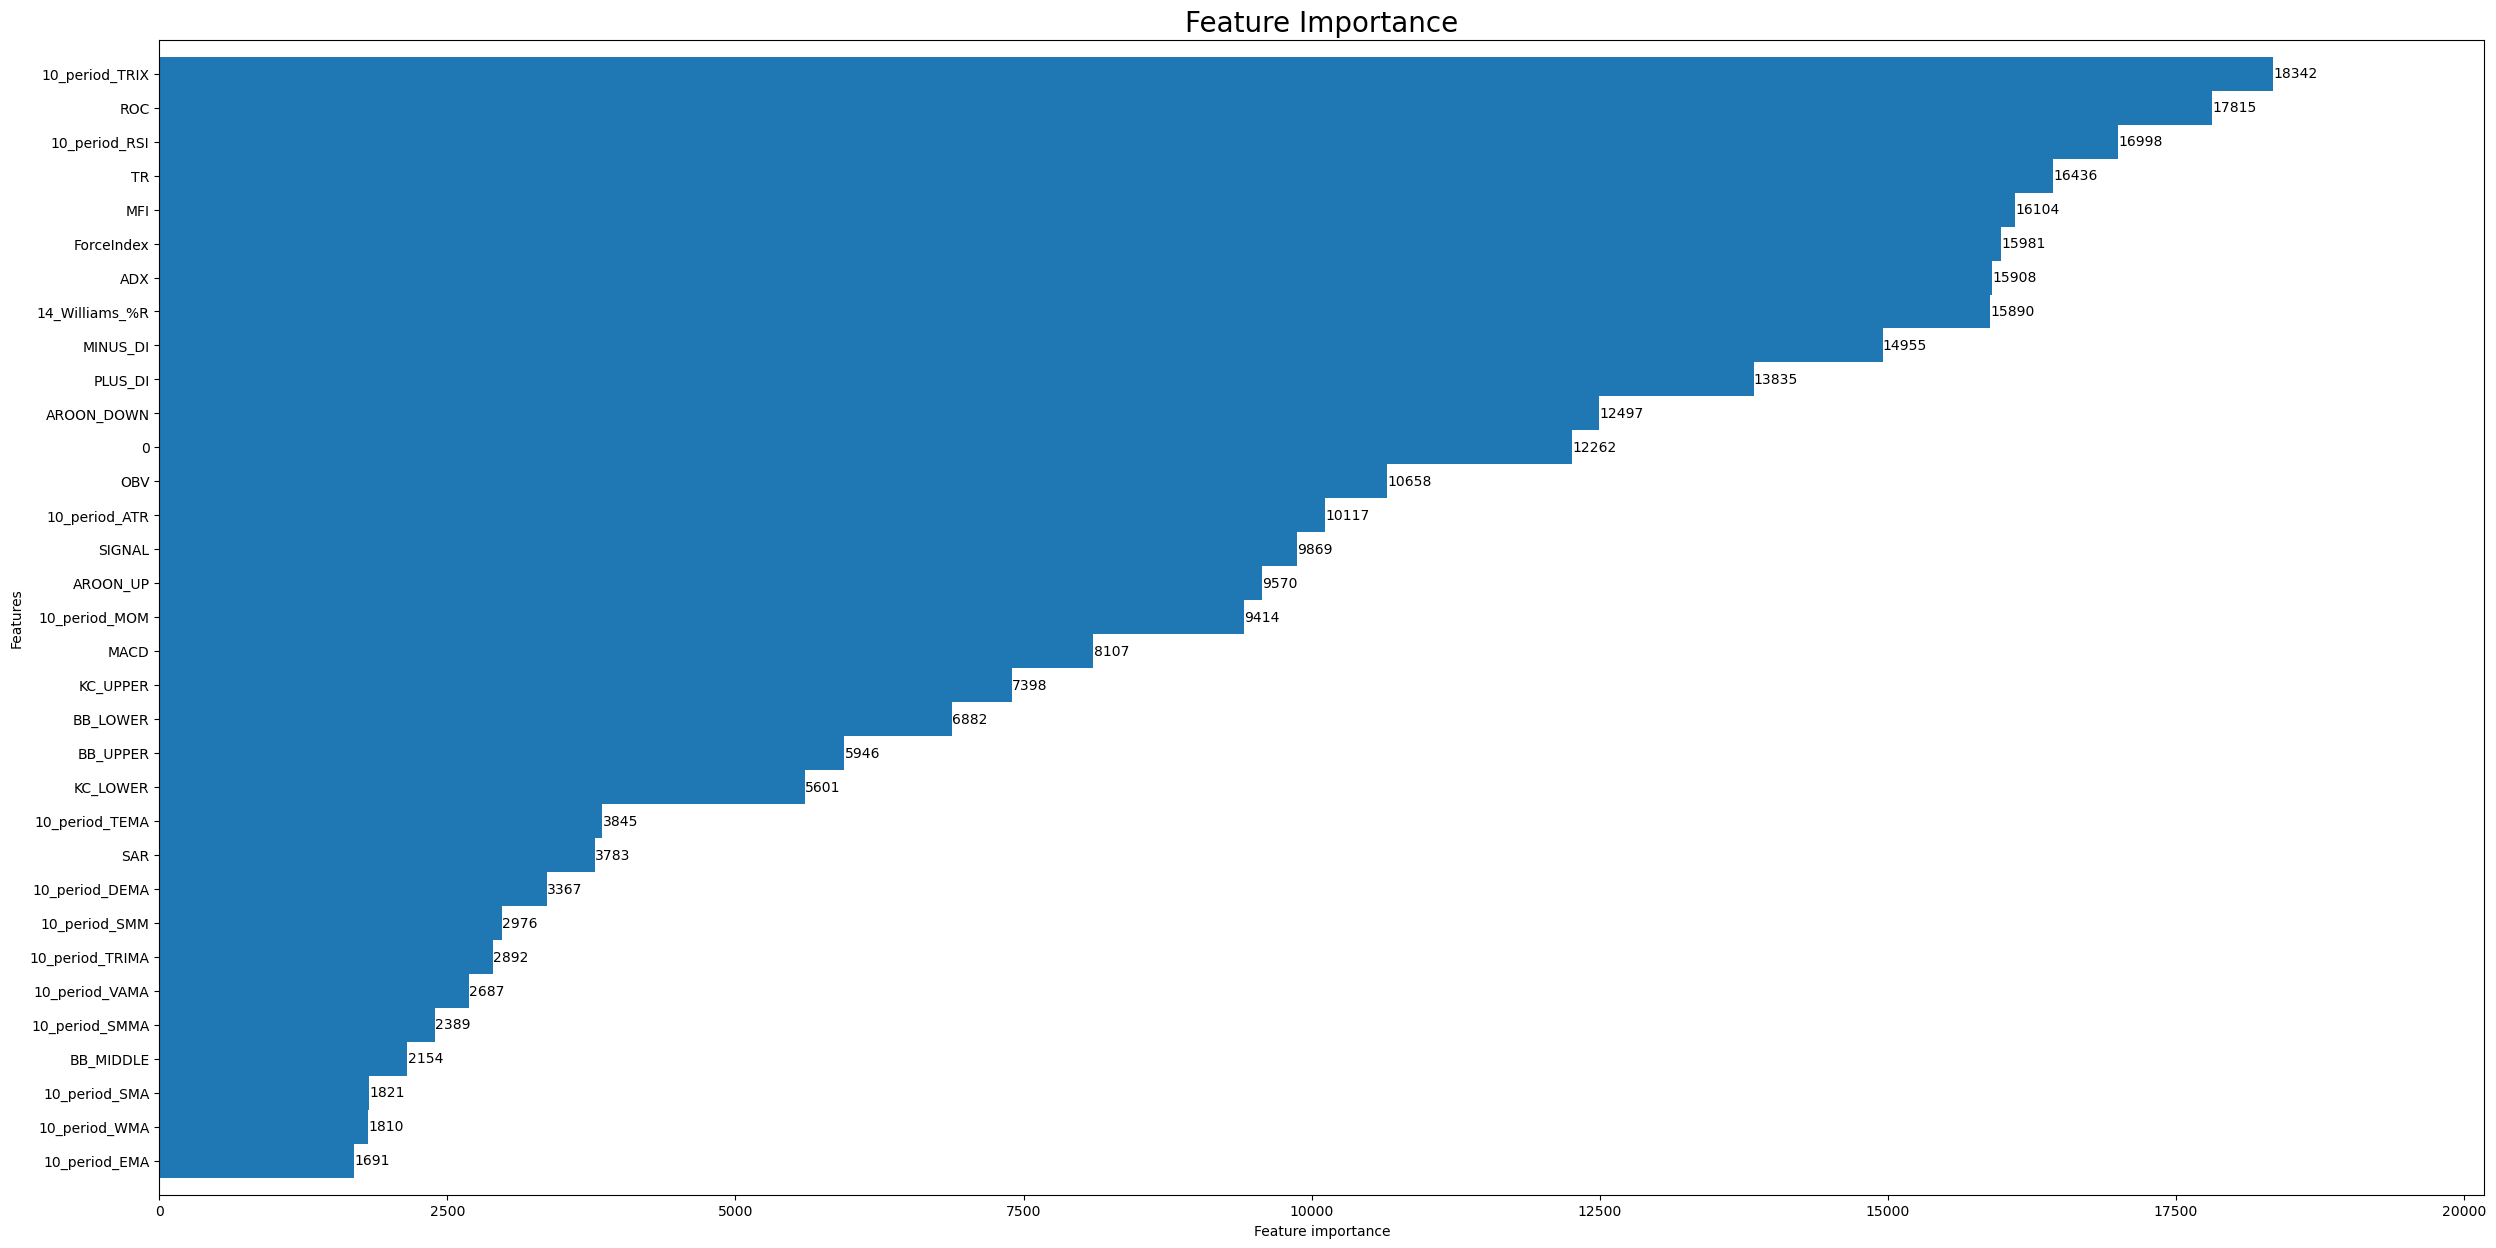

In [17]:
fig, ax = plt.subplots(figsize=(30,15))
lgb.plot_importance(model, height=1, ax=ax)
ax.grid(False)
plt.title("Feature Importance", fontsize=20)
plt.show()

In [18]:
test_df = pd.read_csv("/kaggle/input/jpx-tokyo-stock-exchange-prediction/supplemental_files/stock_prices.csv")
X_test, y_test = preprocess_data(test_df)

In [19]:
y_pred = model.predict(X_test)
print(np.sqrt(mean_squared_error(y_pred, y_test)))

0.03067300280157204


In [20]:
df_pred_and_target = y_test.copy()
df_pred_and_target = df_pred_and_target.join(pd.Series(y_pred, index=df_pred_and_target.index, name="Predict"))
df_pred_and_target

Target   Predict
SecuritiesCode Date                          
1301           2022-04-19  0.007752  0.000171
               2022-04-20 -0.001538 -0.001250
               2022-04-21 -0.007704  0.004247
               2022-04-22  0.013975  0.006338
               2022-04-25 -0.019908  0.003264
...                             ...       ...
9997           2022-06-20  0.001416  0.034720
               2022-06-21  0.000000  0.030778
               2022-06-22  0.016973  0.018029
               2022-06-23  0.013908  0.016989
               2022-06-24  0.015089  0.022749

[269791 rows x 2 columns]

## Calculate Sharpe Ratio

In [21]:
def calc_spread_return_sharpe(df: pd.DataFrame, portfolio_size: int = 200, toprank_weight_ratio: float = 2) -> float:
    """
    Args:
        df (pd.DataFrame): predicted results
        portfolio_size (int): # of equities to buy/sell
        toprank_weight_ratio (float): the relative weight of the most highly ranked stock compared to the least.
    Returns:
        (float): sharpe ratio
    """
    def _calc_spread_return_per_day(df, portfolio_size, toprank_weight_ratio):
        """
        Args:
            df (pd.DataFrame): predicted results
            portfolio_size (int): # of equities to buy/sell
            toprank_weight_ratio (float): the relative weight of the most highly ranked stock compared to the least.
        Returns:
            (float): spread return
        """
        assert df['Rank'].min() == 0
        assert df['Rank'].max() == len(df['Rank']) - 1
        weights = np.linspace(start=toprank_weight_ratio, stop=1, num=portfolio_size)
        purchase = (df.sort_values(by='Rank')['Target'][:portfolio_size] * weights).sum() / weights.mean()
        short = (df.sort_values(by='Rank', ascending=False)['Target'][:portfolio_size] * weights).sum() / weights.mean()
        return purchase - short

    buf = df.groupby('Date').apply(_calc_spread_return_per_day, portfolio_size, toprank_weight_ratio)
    sharpe_ratio = buf.mean() / buf.std()
    return sharpe_ratio

def add_rank(df):
    df["Rank"] = df.groupby("Date")["Target"].rank(ascending=False, method="first") - 1 
    df["Rank"] = df["Rank"].astype("int")
    return df

In [3]:
result = df_pred_and_target.copy()
result = add_rank(result)
result

NameError: name 'df_pred_and_target' is not defined

In [23]:
calc_spread_return_sharpe(result)

4.854728646160476

## API

In [24]:
import jpx_tokyo_market_prediction

sample_submission = pd.read_csv("../input/jpx-tokyo-stock-exchange-prediction/example_test_files/sample_submission.csv")

env = jpx_tokyo_market_prediction.make_env()
iter_test = env.iter_test()

for (prices, options, financials, trades, secondary_prices, sample_prediction) in iter_test:  
    X, y = preprocess_data(prices)
    y_pred = model.predict(X)
    df_pred_and_target = y.copy()
    df_pred_and_target = df_pred_and_target.join(pd.Series(y_pred, index=df_pred_and_target.index, name="Predict"))
    df_pred_and_target = add_rank(df_pred_and_target)
    sample_prediction['Rank'] = df_pred_and_target['Rank']
    env.predict(sample_prediction)
    
sample_prediction.head(10)

ModuleNotFoundError: No module named 'jpx_tokyo_market_prediction.competition'